In [1]:
%matplotlib inline
import pandas as pd
import requests
import numpy as np
import seaborn as sns

import roc_results

In [2]:
response = requests.get('http://localhost:8000/result/')
rec = []
for r in response.json():
    svm = r.get('algorithm').get('svm')
    if r.get('data_length') == 0:
        rec.append({
            'kernel': svm.get('kernel'),
            'c': svm.get('c'),
            'gamma': svm.get('gamma'),
            'coef0': svm.get('coef0'),
            'roc_auc_score': r.get('roc_auc_score'),
            'stock': r.get('stock')
        })
df = pd.DataFrame(rec)

In [3]:
len(df)

31441

In [4]:
log_res = []
for i, row in df.iterrows():
    log_res.append(roc_results.results.get(row['stock']))
df['log_res'] = log_res
df['diff'] = df['roc_auc_score'] - log_res

In [5]:
print(len(df['stock'].unique()))
print(len(df[df['log_res'] <= df['roc_auc_score']]['stock'].unique()))

98
96


In [6]:
df[df['log_res'] <= df['roc_auc_score']].head()

,c,coef0,gamma,kernel,roc_auc_score,stock,log_res,diff
0,100.0,0.0,-1.0,linear,0.563885,9094,0.562067,0.001818
1,1000.0,0.0,-1.0,linear,0.563885,9094,0.562067,0.001818
4,1.0,0.0,-1.0,linear,0.550741,9270,0.550734,0.000007
5,10.0,0.0,-1.0,linear,0.550741,9270,0.550734,0.000007
6,100.0,0.0,-1.0,linear,0.550741,9270,0.550734,0.000007


In [9]:
bests = []
df_best_agg = df.groupby('stock', as_index=False)['diff'].idxmax()
df_bests = df.loc[df_best_agg]
df_bests.index = df_bests['stock']

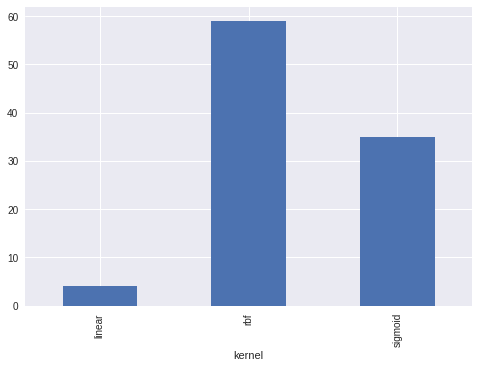

In [10]:
df_bests.groupby('kernel')['kernel'].count().plot(kind='bar')

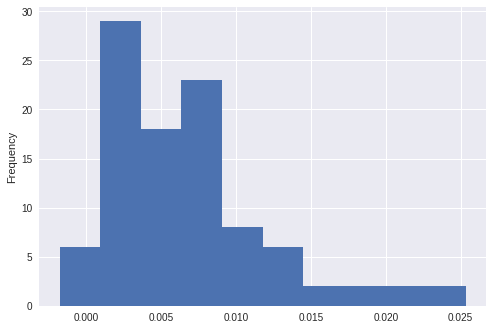

In [11]:
df_bests['diff'].plot(kind='hist')

In [8]:
df.groupby('stock').aggregate({'roc_auc_score': np.max}).head()

,roc_auc_score
stock,
10166,0.564622
10470,0.598329
10484,0.555384
10508,0.568278
10795,0.610659


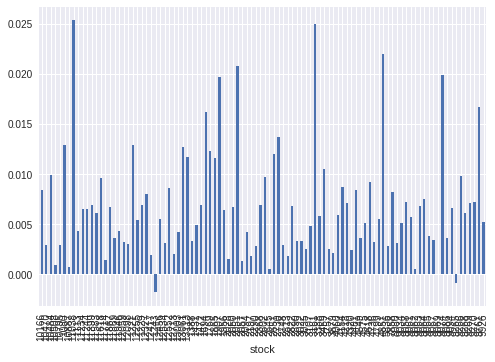

In [12]:
df_bests['diff'].plot(kind='bar')

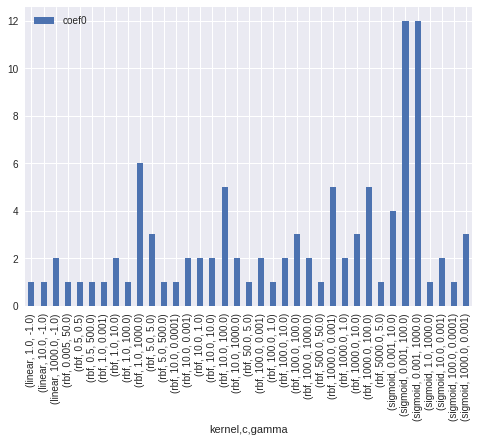

In [13]:
df_bests.groupby(['kernel', 'c', 'gamma'])[['coef0']].count().plot(kind='bar')

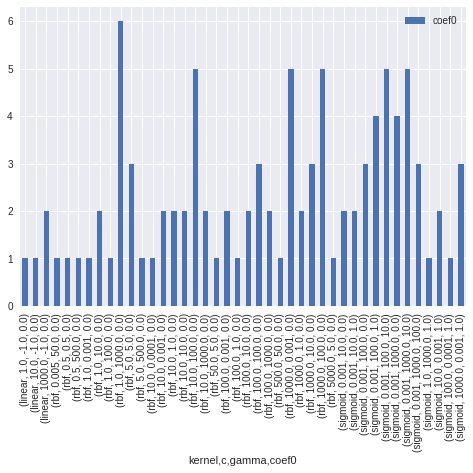

In [14]:
df_bests.groupby(['kernel', 'c', 'gamma', 'coef0'])[['coef0']].count().plot(kind='bar')

In [15]:
# TODO: mean square error by kernel for the bests? or for all


In [16]:
print(df_bests[df_bests['kernel'] == 'rbf']['diff'].median())
print(df_bests[df_bests['kernel'] == 'sigmoid']['diff'].median())
print(df_bests[df_bests['kernel'] == 'linear']['diff'].median())

0.0061533125718047366
0.0056821391582716485
0.003189477217372727


In [17]:
print(df_bests[df_bests['kernel'] == 'rbf']['diff'].std())
print(df_bests[df_bests['kernel'] == 'sigmoid']['diff'].std())
print(df_bests[df_bests['kernel'] == 'linear']['diff'].std())

0.00532108545597995
0.005725766347671549
0.0023922908807642346


In [18]:
print(df_bests[df_bests['kernel'] == 'rbf']['diff'].mean())
print(df_bests[df_bests['kernel'] == 'sigmoid']['diff'].mean())
print(df_bests[df_bests['kernel'] == 'linear']['diff'].mean())

0.0066166224753151995
0.007257034461218888
0.0037261899939127485


In [19]:
print(df_bests[df_bests['kernel'] == 'rbf'][df_bests['diff'] < 0]['diff'].mean())
print(df_bests[df_bests['kernel'] == 'sigmoid'][df_bests['diff'] < 0]['diff'].mean())
print(df_bests[df_bests['kernel'] == 'linear'][df_bests['diff'] < 0]['diff'].mean())

-0.0013156631909403416
nan
nan


/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
print(df_bests[df_bests['kernel'] == 'rbf'][df_bests['diff'] < 0]['diff'].min())
print(df_bests[df_bests['kernel'] == 'sigmoid'][df_bests['diff'] < 0]['diff'].min())
print(df_bests[df_bests['kernel'] == 'linear'][df_bests['diff'] < 0]['diff'].min())

-0.00177292200414
nan
nan


/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/vevurka/.conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
bad_stocks = df_bests[df_bests['diff'] < 0]['stock'].unique()

## summary

In [21]:
from roc_results import results #results_even_data as results
import lob
df_roc = pd.DataFrame()
df_roc['stock'] = results.keys()
df_roc['roc_area'] = results.values()

df_roc = df_roc.sort_values(by='roc_area', ascending=False)

dfs = {}
dfs_test = {}

stocks = df_roc['stock'].values

for s in stocks:
    d, d_test = lob.load_prepared_data(s, data_dir='../data/prepared/', length=None)
    dfs[s] = d
    dfs_test[s] = d_test

Len of data for  2028 is 6279
Training set length for 2028: 5024
Testing set length for 2028: 1255
Len of data for  2197 is 7286
Training set length for 2197: 5829
Testing set length for 2197: 1457
Len of data for  12098 is 5986
Training set length for 12098: 4789
Testing set length for 12098: 1197
Len of data for  12552 is 9049
Training set length for 12552: 7240
Testing set length for 12552: 1809
Len of data for  1221 is 6355
Training set length for 1221: 5084
Testing set length for 1221: 1271
Len of data for  10795 is 7492
Training set length for 10795: 5994
Testing set length for 10795: 1498
Len of data for  2748 is 5489
Training set length for 2748: 4392
Testing set length for 2748: 1097
Len of data for  4154 is 5737
Training set length for 4154: 4590
Testing set length for 4154: 1147
Len of data for  3459 is 7639
Training set length for 3459: 6112
Testing set length for 3459: 1527
Len of data for  3757 is 7298
Training set length for 3757: 5839
Testing set length for 3757: 1459
L

Len of data for  9069 is 17080
Training set length for 9069: 13664
Testing set length for 9069: 3416
Len of data for  1907 is 10499
Training set length for 1907: 8400
Testing set length for 1907: 2099
Len of data for  9061 is 17245
Training set length for 9061: 13796
Testing set length for 9061: 3449
Len of data for  5836 is 10892
Training set length for 5836: 8714
Testing set length for 5836: 2178
Len of data for  9265 is 15986
Training set length for 9265: 12789
Testing set length for 9265: 3197
Len of data for  9269 is 15689
Training set length for 9269: 12552
Testing set length for 9269: 3137
Len of data for  10484 is 10693
Training set length for 10484: 8555
Testing set length for 10484: 2138
Len of data for  9064 is 17676
Training set length for 9064: 14141
Testing set length for 9064: 3535
Len of data for  11867 is 14269
Training set length for 11867: 11416
Testing set length for 11867: 2853
Len of data for  11244 is 17518
Training set length for 11244: 14015
Testing set length 

In [22]:
df_roc = pd.DataFrame()
df_roc['stock'] = [s for s in results.keys() if s in stocks]
df_roc['roc_area'] = [results[s] for s in results.keys() if s in stocks]
df_roc = df_roc.sort_values(by='roc_area', ascending=False)
df_roc.head()

,stock,roc_area
94,2028,0.616323
62,2197,0.614852
26,12098,0.611904
64,12552,0.611180
16,1221,0.610522


In [23]:
df_summary = pd.DataFrame(index=stocks)
sum_sell_ask_mean = []
sum_buy_bid_mean = []
max_trade_price = []
min_trade_price = []
bid_ask_spread = []
pearson_corrs1 = []
pearson_corrs2 = []
bid_len = []
ask_len = []
from scipy.stats import pearsonr
for s in stocks:
    sum_sell_ask_mean.append(dfs[s]['sum_sell_ask'].mean())
    sum_buy_bid_mean.append(dfs[s]['sum_buy_bid'].mean())
    max_trade_price.append(max( dfs[s]['bid_price'].max(), dfs[s]['ask_price'].max()))
    min_trade_price.append(max( dfs[s]['bid_price'].min(), dfs[s]['ask_price'].min()))
    bid_ask_spread.append((dfs[s]['ask_price'] - dfs[s]['bid_price']).mean())
    p1, p2 = pearsonr(dfs[s]['queue_imbalance'], dfs[s]['mid_price'])
    pearson_corrs1.append(p1)
    pearson_corrs2.append(p2)
    max_len_bid = 0
    max_len_ask = 0
    for i, row in dfs[s].iterrows():
        if len(row['bid']) > max_len_bid:
            max_len_bid = len(row['bid'])
        if len(row['ask']) > max_len_ask:
            max_len_ask = len(row['ask'])

    bid_len.append(max_len_bid)
    ask_len.append(max_len_ask)
df_summary['roc_area'] = df_roc['roc_area'].values
df_summary['sum_sell_ask_mean'] = sum_sell_ask_mean
df_summary['sum_buy_bid_mean'] = sum_buy_bid_mean
df_summary['diff_mean_bid_ask'] = df_summary['sum_sell_ask_mean'] - df_summary['sum_buy_bid_mean']
df_summary['max_trade_price'] = max_trade_price
df_summary['min_trade_price'] = min_trade_price
df_summary['diff_trade_price'] = df_summary['max_trade_price'] - df_summary['min_trade_price']
df_summary['bid_ask_spread'] = bid_ask_spread
df_summary['pearson_corr1'] = pearson_corrs1
df_summary['pearson_corr2'] = pearson_corrs2
df_summary['len_ask'] = ask_len
df_summary['len_bid'] = bid_len

df_summary.sort_values(by='bid_ask_spread')[df_summary['roc_area'] >= 0.58].head()


,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid
2028,0.616323,39899.973726,40336.946656,-436.972930,130.3,102.6,27.7,0.139849,0.020089,1.545297e-01,1326,1236
2890,0.586899,18529.187925,16084.068188,2445.119738,202.5,173.2,29.3,0.151702,0.039010,5.098050e-04,1019,886
1956,0.581724,7641.837035,8492.734066,-850.897030,306.4,264.8,41.6,0.153452,0.091559,6.845194e-17,1070,846
11946,0.582509,17693.761818,17930.643211,-236.881393,206.1,183.6,22.5,0.170185,0.048886,8.671961e-06,939,812
3035,0.583822,6350.159385,5920.926133,429.233252,263.7,235.9,27.8,0.191565,0.044378,3.908516e-05,810,717


In [24]:
df_bests.sort_index(inplace=True)
df_summary.sort_index(inplace=True)
df_all = df_bests.join(df_summary)

In [25]:
df_all.head()

,c,coef0,gamma,kernel,roc_auc_score,stock,log_res,diff,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid
stock,,,,,,,,,,,,,,,,,,,,
10166,0.001,10.0,1000.0,sigmoid,0.564622,10166,0.556248,0.008374,0.556248,824.059050,813.630580,10.428470,3454.5,2965.0,489.5,1.252224,-0.021872,1.369988e-02,1222,1446
10470,0.001,1.0,100.0,sigmoid,0.598329,10470,0.595373,0.002956,0.595373,1027.934070,1116.398830,-88.464759,2510.0,2076.0,434.0,1.678153,0.048772,1.879255e-05,737,844
10484,0.001,10.0,100.0,sigmoid,0.555384,10484,0.545468,0.009916,0.545468,2759.086382,2904.950088,-145.863705,361.1,316.2,44.9,0.289912,0.062488,7.269869e-09,740,682
10508,0.001,10.0,100.0,sigmoid,0.568278,10508,0.567335,0.000944,0.567335,3696.349391,3780.748030,-84.398639,385.6,341.3,44.3,0.251325,-0.026839,4.560869e-03,749,834
10795,1000.000,0.0,10.0,rbf,0.610659,10795,0.607709,0.002949,0.607709,2445.049383,2126.907241,318.142142,1644.0,1440.0,204.0,1.597764,-0.005801,6.533850e-01,597,598


In [26]:
df_summary.head()

,roc_area,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid
10166,0.556248,824.059050,813.630580,10.428470,3454.5,2965.0,489.5,1.252224,-0.021872,1.369988e-02,1222,1446
10470,0.595373,1027.934070,1116.398830,-88.464759,2510.0,2076.0,434.0,1.678153,0.048772,1.879255e-05,737,844
10484,0.545468,2759.086382,2904.950088,-145.863705,361.1,316.2,44.9,0.289912,0.062488,7.269869e-09,740,682
10508,0.567335,3696.349391,3780.748030,-84.398639,385.6,341.3,44.3,0.251325,-0.026839,4.560869e-03,749,834
10795,0.607709,2445.049383,2126.907241,318.142142,1644.0,1440.0,204.0,1.597764,-0.005801,6.533850e-01,597,598


In [27]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98 entries, 10166 to 9926
Data columns (total 12 columns):
roc_area             98 non-null float64
sum_sell_ask_mean    98 non-null float64
sum_buy_bid_mean     98 non-null float64
diff_mean_bid_ask    98 non-null float64
max_trade_price      98 non-null float64
min_trade_price      98 non-null float64
diff_trade_price     98 non-null float64
bid_ask_spread       98 non-null float64
pearson_corr1        98 non-null float64
pearson_corr2        98 non-null float64
len_ask              98 non-null int64
len_bid              98 non-null int64
dtypes: float64(10), int64(2)
memory usage: 12.5+ KB


In [28]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(["sigmoid", "linear", "rbf"])
df_all['kernel_class'] = le.transform(df_all['kernel'])
df_all.head()

,c,coef0,gamma,kernel,roc_auc_score,stock,log_res,diff,roc_area,sum_sell_ask_mean,...,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid,kernel_class
stock,,,,,,,,,,,,,,,,,,,,,
10166,0.001,10.0,1000.0,sigmoid,0.564622,10166,0.556248,0.008374,0.556248,824.059050,...,10.428470,3454.5,2965.0,489.5,1.252224,-0.021872,1.369988e-02,1222,1446,2
10470,0.001,1.0,100.0,sigmoid,0.598329,10470,0.595373,0.002956,0.595373,1027.934070,...,-88.464759,2510.0,2076.0,434.0,1.678153,0.048772,1.879255e-05,737,844,2
10484,0.001,10.0,100.0,sigmoid,0.555384,10484,0.545468,0.009916,0.545468,2759.086382,...,-145.863705,361.1,316.2,44.9,0.289912,0.062488,7.269869e-09,740,682,2
10508,0.001,10.0,100.0,sigmoid,0.568278,10508,0.567335,0.000944,0.567335,3696.349391,...,-84.398639,385.6,341.3,44.3,0.251325,-0.026839,4.560869e-03,749,834,2
10795,1000.000,0.0,10.0,rbf,0.610659,10795,0.607709,0.002949,0.607709,2445.049383,...,318.142142,1644.0,1440.0,204.0,1.597764,-0.005801,6.533850e-01,597,598,1


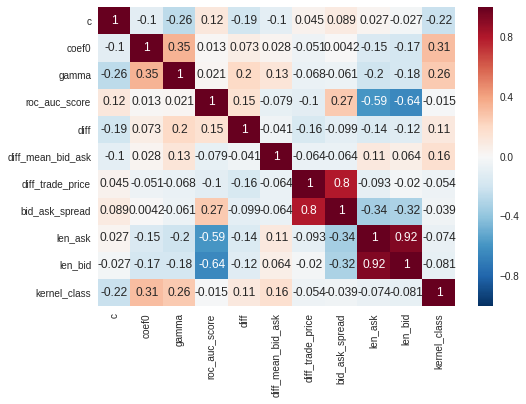

In [29]:
features = ['c', 'coef0', 'gamma', 'roc_auc_score', 'diff', 
            'diff_mean_bid_ask', 'diff_trade_price', 
            'bid_ask_spread', 'len_ask', 'len_bid', 'kernel_class']
sns.heatmap(df_all[features].corr(), annot=True)

## Clustering

In [30]:
data_lens = []
for s in df_all.index:
    data_lens.append(len(dfs[s]))
df_all['data_len'] = data_lens
df_all.head()

,c,coef0,gamma,kernel,roc_auc_score,stock,log_res,diff,roc_area,sum_sell_ask_mean,...,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid,kernel_class,data_len
stock,,,,,,,,,,,,,,,,,,,,,
10166,0.001,10.0,1000.0,sigmoid,0.564622,10166,0.556248,0.008374,0.556248,824.059050,...,3454.5,2965.0,489.5,1.252224,-0.021872,1.369988e-02,1222,1446,2,12701
10470,0.001,1.0,100.0,sigmoid,0.598329,10470,0.595373,0.002956,0.595373,1027.934070,...,2510.0,2076.0,434.0,1.678153,0.048772,1.879255e-05,737,844,2,7690
10484,0.001,10.0,100.0,sigmoid,0.555384,10484,0.545468,0.009916,0.545468,2759.086382,...,361.1,316.2,44.9,0.289912,0.062488,7.269869e-09,740,682,2,8555
10508,0.001,10.0,100.0,sigmoid,0.568278,10508,0.567335,0.000944,0.567335,3696.349391,...,385.6,341.3,44.3,0.251325,-0.026839,4.560869e-03,749,834,2,11168
10795,1000.000,0.0,10.0,rbf,0.610659,10795,0.607709,0.002949,0.607709,2445.049383,...,1644.0,1440.0,204.0,1.597764,-0.005801,6.533850e-01,597,598,1,5994


In [31]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
features = ['len_bid', 'len_ask', 'bid_ask_spread', 'data_len']

X = df_all[features]

kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(X)

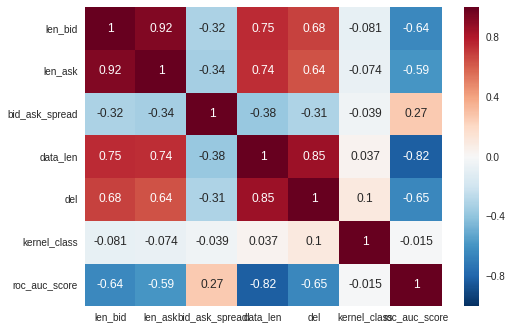

In [32]:
df_all['del'] = kmeans
sns.heatmap(df_all[features + ['del', 'kernel_class', 'roc_auc_score' ]].corr(), 
            annot=True)

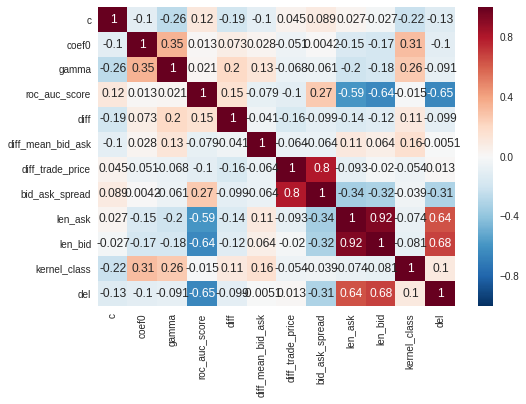

In [33]:
features = ['c', 'coef0', 'gamma', 'roc_auc_score', 'diff', 
            'diff_mean_bid_ask', 'diff_trade_price', 
            'bid_ask_spread', 'len_ask', 'len_bid', 'kernel_class', 'del']
sns.heatmap(df_all[features].corr(), annot=True)

## Check bad ones

In [44]:
f = ['sum_sell_ask_mean', 'sum_buy_bid_mean',
       'diff_mean_bid_ask', 'max_trade_price', 'min_trade_price',
       'diff_trade_price', 'bid_ask_spread', 'pearson_corr1', 'pearson_corr2',
       'len_ask', 'len_bid', 'data_len']
df_all[f][df_all['diff'] < 0]

,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid,data_len
stock,,,,,,,,,,,,
1243,3494.305032,3744.672258,-250.367226,1140.0,867.5,272.5,0.933427,0.014848,2.230222e-01,1240,920,6737
9265,1261.252483,1269.560013,-8.307530,3559.5,3163.5,396.0,0.994918,-0.099897,9.937411e-30,1698,1733,12789


In [45]:
df_all[f].describe()

,sum_sell_ask_mean,sum_buy_bid_mean,diff_mean_bid_ask,max_trade_price,min_trade_price,diff_trade_price,bid_ask_spread,pearson_corr1,pearson_corr2,len_ask,len_bid,data_len
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,9.800000e+01,98.000000,98.000000,98.000000
mean,5469.513337,5471.404824,-1.891488,1445.780918,1234.898469,210.882449,1.015490,0.016420,1.291002e-01,1108.571429,1102.540816,8488.734694
std,6949.313300,6895.902551,460.293644,1178.842667,1003.545334,187.816532,0.834730,0.040145,2.273646e-01,542.949600,515.316141,2717.646566
min,244.583703,275.377776,-1236.489997,80.880000,72.700000,8.180000,0.024897,-0.099897,1.310290e-36,423.000000,463.000000,4392.000000
25%,2008.697275,1984.746351,-141.055909,455.500000,383.575000,62.837500,0.275285,-0.005659,2.084033e-05,756.500000,772.250000,6129.250000
50%,3504.550654,3432.737426,-21.954670,1207.000000,1006.500000,156.000000,0.844839,0.019762,5.085691e-03,989.500000,933.500000,8302.000000
75%,5934.619527,5836.912394,80.411225,1892.250000,1694.750000,272.500000,1.578652,0.040510,1.697329e-01,1261.000000,1294.250000,10911.500000
max,41718.408675,42268.554239,2445.119738,5760.000000,4911.000000,849.000000,5.267532,0.118317,8.967269e-01,3101.000000,2972.000000,14141.000000
